# Time Series Forecasting w/ VAR Vector Auto - regressif ¶

In [1]:
# import warnings
# warnings.filterwarnings("ignore")
# Compatibility between Python 2.7 and 3.x
#from __future__ import unicode_literals, print_function, division
from io import open
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
#from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from pandas.plotting import autocorrelation_plot
#style.use('fivethirtyeight')
%matplotlib inline

import copy 
import math

import psycopg2

import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
## from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.layers import LSTM
# from keras import metrics
# from keras.wrappers.scikit_learn import KerasClassifier#

# Custom utility functions shared across notebooks
#import utils## Data Loading

In [3]:
#Set up plot functions
def plt_(dataset):    
    plt.figure(figsize=(12,6))
    plt.plot(dataset, color = 'b')
    plt.show()
    
def density_plt_(dataset):
    plt.figure(figsize=(12,6))
    sns.distplot(dataset)
    plt.show()
    
#Decomposition
def decomp_plt_(dataset):
    decomposition = seasonal_decompose(dataset)
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(411)
    ax.plot(dataset, label='Original', color = 'b')
    ax.legend(loc='best')
    ax = fig.add_subplot(412)
    ax.plot(decomposition.trend, label='Trend', color = 'b')
    ax.legend(loc='best')
    ax = fig.add_subplot(413)
    ax.plot(decomposition.seasonal,label='Seasonality', color = 'b')
    ax.legend(loc='best')
    ax= fig.add_subplot(414)
    ax.plot(decomposition.resid, label='Residuals', color = 'b')
    ax.legend(loc='best')
    plt.show()

## Data Loading

In [ ]:

try:
    connection = psycopg2.connect(user="sesyr",
                                  password="SeSyR54",
                                  host="51.254.68.36",
                                  port="5432",
                  
                                  database="donnees_trafic")
    cursor = connection.cursor()

    # Print PostgreSQL version
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record,"\n")
    
    postgreSQL_select_Query = """
    WITH metadata AS (
          SELECT ist.macrosection,
         ist.code_centrale,
         cnl.code_canal,
         sc.sens,
         cc.id_nature_mesure, cc.libelle
        FROM rdv.info_section_troncon ist
        JOIN rdv.sens_canal sc ON sc.sens::text = ist.sens::text
    JOIN myrabel.centrale c ON c.code_centrale = ist.code_centrale::bpchar
    JOIN myrabel.canal cnl ON cnl.id_centrale = c.id_centrale AND cnl.code_canal::text = sc.canal::text
    JOIN myrabel.cal_canal cc ON cc.id_canal = cnl.id_canal AND cc.libelle ~~ '%QT_360 %'::text
    
    ), metadatavt AS (
          SELECT distinct ist.macrosection,
         ist.code_centrale,
         cnl.code_canal,
         sc.sens,
         cc.id_nature_mesure, cc.libelle
        FROM rdv.info_section_troncon ist
        JOIN rdv.sens_canal sc ON sc.sens::text = ist.sens::text
    JOIN myrabel.centrale c ON c.code_centrale = ist.code_centrale::bpchar
    JOIN myrabel.canal cnl ON cnl.id_centrale = c.id_centrale AND cnl.code_canal::text = sc.canal::text
    JOIN myrabel.cal_canal cc ON cc.id_canal = cnl.id_canal AND cc.libelle ~~ '%VT_360 %'::text
    )
    
    SELECT 
       
       m.macrosection,
       m.sens,
       m.code_centrale,
       m.code_canal, 
       
        
       ts,
       dq.valeur AS qt,
       dv.valeur AS vt
       
       
      FROM metadata  m
      JOIN metadatavt v
      ON m.macrosection = v.macrosection AND m.sens = v.sens AND m.code_centrale = v.code_centrale AND  m.code_canal=  v.code_canal
      
      CROSS JOIN generate_series('2016-05-01' , '2017-05-30','01:00:00'::interval) AS  ts(ts)
      
      LEFT JOIN myrabel.mesure_2 dq    
      ON dq.id_nature_mesure = m.id_nature_mesure
      AND dq.date_mesure = ts 
      
        LEFT JOIN myrabel.mesure_2 dv    
      ON dv.id_nature_mesure = v.id_nature_mesure
      AND dv.date_mesure = ts
      
      
        --WHERE(  dv.date_mesure IS NULL OR dq.date_mesure IS NULL OR dv.date_mesure = dq.date_mesure )
      
     -- WHERE dq.date_mesure IS NOT  NULL AND dv.date_mesure IS NULL  --OR dq.date_mesure IS NULL
      
      """
    

    cursor.execute(postgreSQL_select_Query)
    print("Selecting rows from mobile table using cursor.fetchall")
    records = cursor.fetchall() 
   
   # print("Print each row and it's columns values")
   #for row in records:
       #   print("Macrosection = ", row[0])
        #  print("sens = ", row[1])
         # print("code centrale   = ", row[2])
          #print(" code canal = ", row[3])
        #  print("date_mesure = ", row[4])
         # print("qt_360 = ", row[5]) 
          #print("Vt_360 = ", row[6],"\n" )
            
            
except (Exception, psycopg2.Error) as error :
    print ("Error while connecting to PostgreSQL", error)
        
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")            

You are connected to -  ('PostgreSQL 10.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-28), 64-bit',) 



In [32]:
df = pd.DataFrame(records, columns=['Macrosection','sens','code_centrale','code_canal','date','qt_360','vt_360'])

#strip code canal which is a char of 3 character with whitespace
#df['code_canal'] = df['code_canal'].str.strip()

df.date = pd.to_datetime(df.date, format= "%Y-%m-%d %H" ,utc= True)

df.sort_values(by='date')

df_hours_float = df.date.dt.hour + df.date.dt.minute/60.0


# df['cos_Feature_hour']=np.sin(2.*np.pi*df_hours_float/24.)
# df['sin_Feature_hour']=np.cos(2.*np.pi*df_hours_float/24.)

#df= df.set_index('date')

df = df.drop(["sens", "Macrosection"], axis=1)
#df = df.replace(0,np.NaN) # np.NaN ca va marcher , np.nan doesnt work anymore !!
df['vt_360'] = df['vt_360'].replace(0,np.NaN)
df['qt_360'] = df['qt_360'].replace(0,np.NaN)

df.head()

,code_centrale,code_canal,date,qt_360,vt_360
0,MZE54.3,0,2017-04-30 22:00:00+00:00,33.0,97.0
1,MZE54.3,0,2017-04-30 22:06:00+00:00,26.0,95.0
2,MZE54.3,0,2017-04-30 22:12:00+00:00,36.0,98.0
3,MZE54.3,0,2017-04-30 22:18:00+00:00,29.0,96.0
4,MZE54.3,0,2017-04-30 22:24:00+00:00,37.0,94.0


In [34]:
DataFrameDict=df.groupby(['code_canal','code_centrale'])
    
#print to s
for key, item in DataFrameDict:
    print(DataFrameDict.get_group(key), "\n\n")
    #print (key)
    #DataFrameDict.get_group(key).to_csv(r'C:\Users\hp\Desktop\Stage IOT TS\devellopement\grouping_by_codes'+ str(key) +'.csv')   


     code_centrale code_canal                      date  qt_360  vt_360
0          MZE54.3        0   2017-04-30 22:00:00+00:00    33.0    97.0
1          MZE54.3        0   2017-04-30 22:06:00+00:00    26.0    95.0
2          MZE54.3        0   2017-04-30 22:12:00+00:00    36.0    98.0
3          MZE54.3        0   2017-04-30 22:18:00+00:00    29.0    96.0
4          MZE54.3        0   2017-04-30 22:24:00+00:00    37.0    94.0
5          MZE54.3        0   2017-04-30 22:30:00+00:00    26.0    99.0
6          MZE54.3        0   2017-04-30 22:36:00+00:00    35.0    97.0
7          MZE54.3        0   2017-04-30 22:42:00+00:00    17.0    90.0
8          MZE54.3        0   2017-04-30 22:48:00+00:00    23.0    94.0
9          MZE54.3        0   2017-04-30 22:54:00+00:00    18.0   103.0
10         MZE54.3        0   2017-04-30 23:00:00+00:00    15.0    92.0
11         MZE54.3        0   2017-04-30 23:06:00+00:00    14.0    95.0
12         MZE54.3        0   2017-04-30 23:12:00+00:00    16.0 

       code_centrale code_canal                      date  qt_360   vt_360
167064       SITE_03        3   2017-04-30 22:00:00+00:00     1.0  112.000
167065       SITE_03        3   2017-04-30 22:06:00+00:00     2.0  115.000
167066       SITE_03        3   2017-04-30 22:12:00+00:00     2.0  112.000
167067       SITE_03        3   2017-04-30 22:18:00+00:00     3.0  110.000
167068       SITE_03        3   2017-04-30 22:24:00+00:00     1.0  124.000
167069       SITE_03        3   2017-04-30 22:30:00+00:00     2.0  132.000
167070       SITE_03        3   2017-04-30 22:36:00+00:00     NaN      NaN
167071       SITE_03        3   2017-04-30 22:42:00+00:00     1.0   96.000
167072       SITE_03        3   2017-04-30 22:48:00+00:00     NaN      NaN
167073       SITE_03        3   2017-04-30 22:54:00+00:00     NaN      NaN
167074       SITE_03        3   2017-04-30 23:00:00+00:00     1.0  112.000
167075       SITE_03        3   2017-04-30 23:06:00+00:00     1.0   96.000
167076       SITE_03     

In [35]:
# for k, v in DataFrameDict:
#       ax=DataFrameDict.get_group(k).plot(figsize =(22,10))
#       ax.set_ylabel(k)

In [36]:
group = [0]*len(DataFrameDict)
for i, (k, v) in enumerate(DataFrameDict):
    group[i] = DataFrameDict.get_group(k)

In [37]:
for i in range(len(group)):
      group[i] = group[i].drop(["code_centrale", "code_canal"], axis=1)

#delete  12 because has almots null data


In [38]:
merged = group[0]
for i in range(len(group)-1):
      merged = pd.merge(merged,group[i+1], on='date',how ='left')

In [39]:
merged.columns = ['date',
                  'qt_dv00', 'vt_dv00',
                  'qt_dv01', 'vt_dv01',
                  'qt_dv02', 'vt_dv02',
                  'qt_dv03', 'vt_dv03', 
                  'qt_dv04', 'vt_dv04',
                  
                  'qt_dv05', 'vt_dv05',
                  'qt_dv06', 'vt_dv06',
                  'qt_dv07', 'vt_dv07',
                  'qt_dv08', 'vt_dv08',
                  
                  'qt_dv09', 'vt_dv09',
                  'qt_dv10', 'vt_dv10', 
                  'qt_dv11', 'vt_dv11',
                  'qt_dv12', 'vt_dv12', 
                  'qt_dv13', 'vt_dv13',
                  
                  'qt_dv14', 'vt_dv14',
                  'qt_dv15', 'vt_dv15',
                  'qt_dv16', 'vt_dv16', 
                  'qt_dv17', 'vt_dv17',
                  'qt_dv18', 'vt_dv18',
                  'qt_dv19', 'vt_dv19', 
                  
                  'qt_dv20', 'vt_dv20',
                  'qt_dv21', 'vt_dv21',
                  'qt_dv22', 'vt_dv22',
                  'qt_dv23', 'vt_dv23',
                  'qt_dv24', 'vt_dv24',
                  'qt_dv25', 'vt_dv25', 
                  'qt_dv26', 'vt_dv26'
                  
#                   'cos_Feature_hour',
#                   'sin_Feature_hour'
            ]

,qt_dv18,vt_dv18
0,1.0,55.0
1,4.0,44.0
2,5.0,48.0
3,6.0,47.0
4,2.0,55.0
5,4.0,52.0
6,4.0,50.0
7,1.0,47.0
8,1.0,43.0
9,2.0,43.0


In [41]:
def get_non_null(df):
    lngth = min(list(len(col.dropna()) for ind, col in df.iteritems()))
    df = pd.concat(list(df.loc[:,col].dropna().head(lngth).reset_index(drop=True) for col in df),axis=1)
    return df

In [43]:
# take the data witn Non NaN values the data is adapted in the least number of a column

filtered_df = get_non_null(merged)

filtered_df = filtered_df.set_index("date")

Dataset = filtered_df

Dataset

,date,qt_dv00,vt_dv00,qt_dv01,vt_dv01,qt_dv02,vt_dv02,qt_dv03,vt_dv03,qt_dv04,...,qt_dv22,vt_dv22,qt_dv23,vt_dv23,qt_dv24,vt_dv24,qt_dv25,vt_dv25,qt_dv26,vt_dv26
0,2017-04-30 22:00:00+00:00,33.0,97.0,29.0,96.0,29.0,104.0000,31.0,100.3330,19.0,...,21.0,92.6667,21.0,97.3333,13.0,90.6667,4.0,116.0000,1.0,NaN
1,2017-04-30 22:06:00+00:00,26.0,95.0,23.0,94.0,25.0,101.0000,22.0,96.6667,21.0,...,23.0,84.3333,27.0,98.0000,8.0,87.5000,5.0,97.0000,2.0,104.000
2,2017-04-30 22:12:00+00:00,36.0,98.0,31.0,95.0,33.0,98.6667,34.0,100.3330,31.0,...,16.0,89.0000,18.0,95.0000,12.0,91.3333,5.0,96.5000,NaN,NaN
3,2017-04-30 22:18:00+00:00,29.0,96.0,22.0,92.0,29.0,92.6667,25.0,95.0000,22.0,...,29.0,87.3333,40.0,95.0000,15.0,96.6667,13.0,95.6000,5.0,116.000
4,2017-04-30 22:24:00+00:00,37.0,94.0,40.0,90.0,31.0,97.6667,38.0,99.0000,27.0,...,21.0,87.3333,17.0,95.2000,16.0,87.0000,2.0,90.0000,1.0,110.000
5,2017-04-30 22:30:00+00:00,26.0,99.0,23.0,90.0,19.0,100.6670,22.0,103.3330,25.0,...,16.0,86.8000,17.0,98.0000,20.0,88.0000,4.0,87.3333,NaN,NaN
6,2017-04-30 22:36:00+00:00,35.0,97.0,29.0,93.0,35.0,99.0000,34.0,99.3333,22.0,...,13.0,86.6667,16.0,94.0000,9.0,83.5000,1.0,84.0000,1.0,98.000
7,2017-04-30 22:42:00+00:00,17.0,90.0,16.0,89.0,17.0,100.6670,21.0,91.6667,23.0,...,10.0,88.6667,9.0,93.3333,10.0,89.2000,1.0,78.0000,NaN,NaN
8,2017-04-30 22:48:00+00:00,23.0,94.0,15.0,89.0,20.0,95.6667,18.0,98.3333,7.0,...,9.0,87.6000,14.0,91.6667,6.0,82.0000,4.0,100.6670,NaN,NaN
9,2017-04-30 22:54:00+00:00,18.0,103.0,22.0,93.0,16.0,104.4000,18.0,103.6000,19.0,...,10.0,86.8000,10.0,93.5000,6.0,74.5000,2.0,94.0000,NaN,NaN


In [15]:
def NonZdata(data,col):
  start = np.where(data[:,col] == 0)
  #print(start[0][0])
  x0 = data[:start[0][0],col]
  if np.shape(x0)[0] > 100:
    return x0
  else:
    g=np.diff(start)
    gap = np.amax(g[0])
    index = np.where(g[0]== gap)
    x1 = data[ start[0][index[0][0]] : start[0][index[0][0]+1] , col ]
    return x1

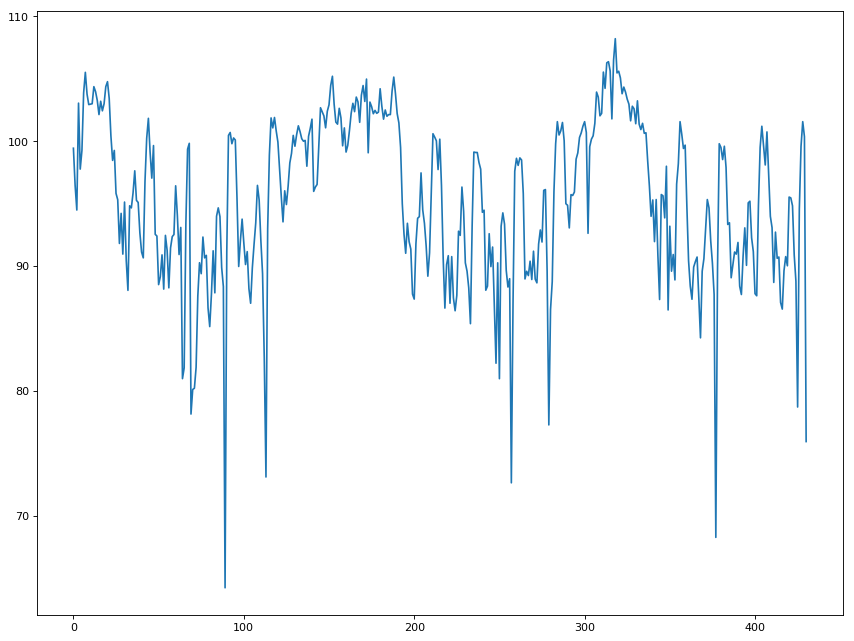

In [16]:
np_nan = np.matrix(Dataset)  #convert dataframe to matrix
   
np_clean =  np.nan_to_num(np_nan) #convert NaNs to 0's

t0=NonZdata(np_clean,5)

plt.figure(num=1, figsize=(13, 10), dpi=80)
plt.plot(t0)
plt.show()

# t1=NonZdata(np_clean[],5)

# plt.figure(num = 2 , figsize=(13, 10), dpi=80)
# plt.plot(t1)
# plt.show()


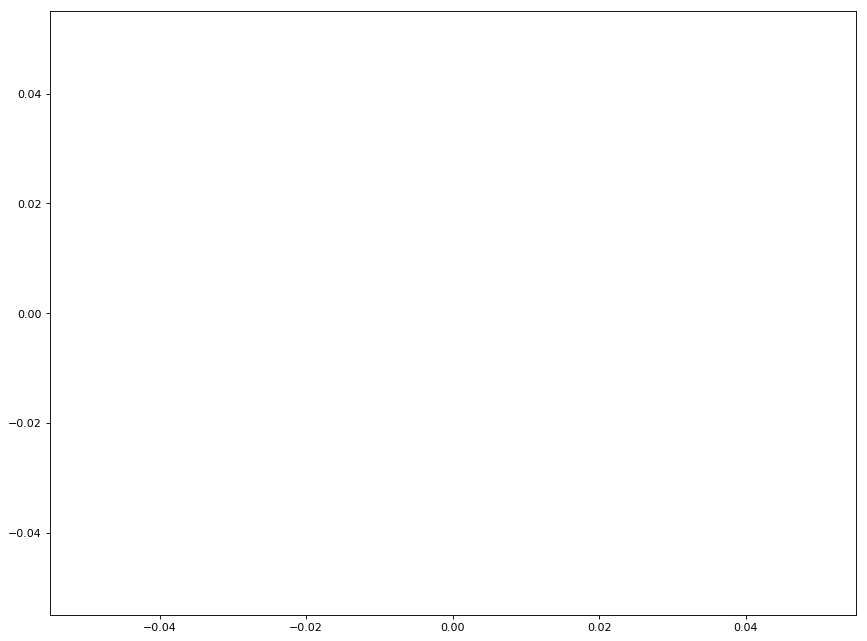

In [17]:
s = np.shape(t0)[0]
#np.shape(np_clean[s:,5])
t1 = NonZdata(np_clean[s:,:],5)

plt.figure(num = 2 , figsize=(13, 10), dpi=80)
plt.plot(t1)
plt.show()


### Check for stationarity :

What is meant by checking the stationarity of a time series and why do you care about it?

In a stationary time series, the statistical properties over time must be constant and autoconvariance must be time independent. Normally, when running a regular regression, you expect the observations to be independent of each other. In a time series, however, you know that the observations are time dependent. In order to use regression techniques on time dependent variables, the data must be stationary. The techniques that apply to independent random variables also apply to stationary random variables.

There are two ways to check the stationarity of a time series. The first is plot the moving variance and observe if it remains constant over time. However, you might not always be able to make such visual inferences. The second way is to use the Dickey-Fuller test, a statistical test with the null hypothesis that the time series is non-stationary. If the test results in the test statistic significantly less than the critical values, we can reject the null hypothesis in favor of time series stationarity.

Calculate the moving variances, plot the results and apply the Dickey-Fuller test on the time series:

In [18]:
def check_stationarity(timeseries):
    
    #Determing rolling statistics
    rolling_mean = timeseries.rolling(window=52,center=False).mean() 
    rolling_std = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    plt.figure(num=1, figsize=(20, 15), dpi=80)

    original = plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolling_mean.index.to_pydatetime(), rolling_mean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std.index.to_pydatetime(), rolling_std.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dickey_fuller_test = adfuller(timeseries, autolag='AIC')
    dfresults = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfresults['Critical Value (%s)'%key] = value
    print (dfresults)

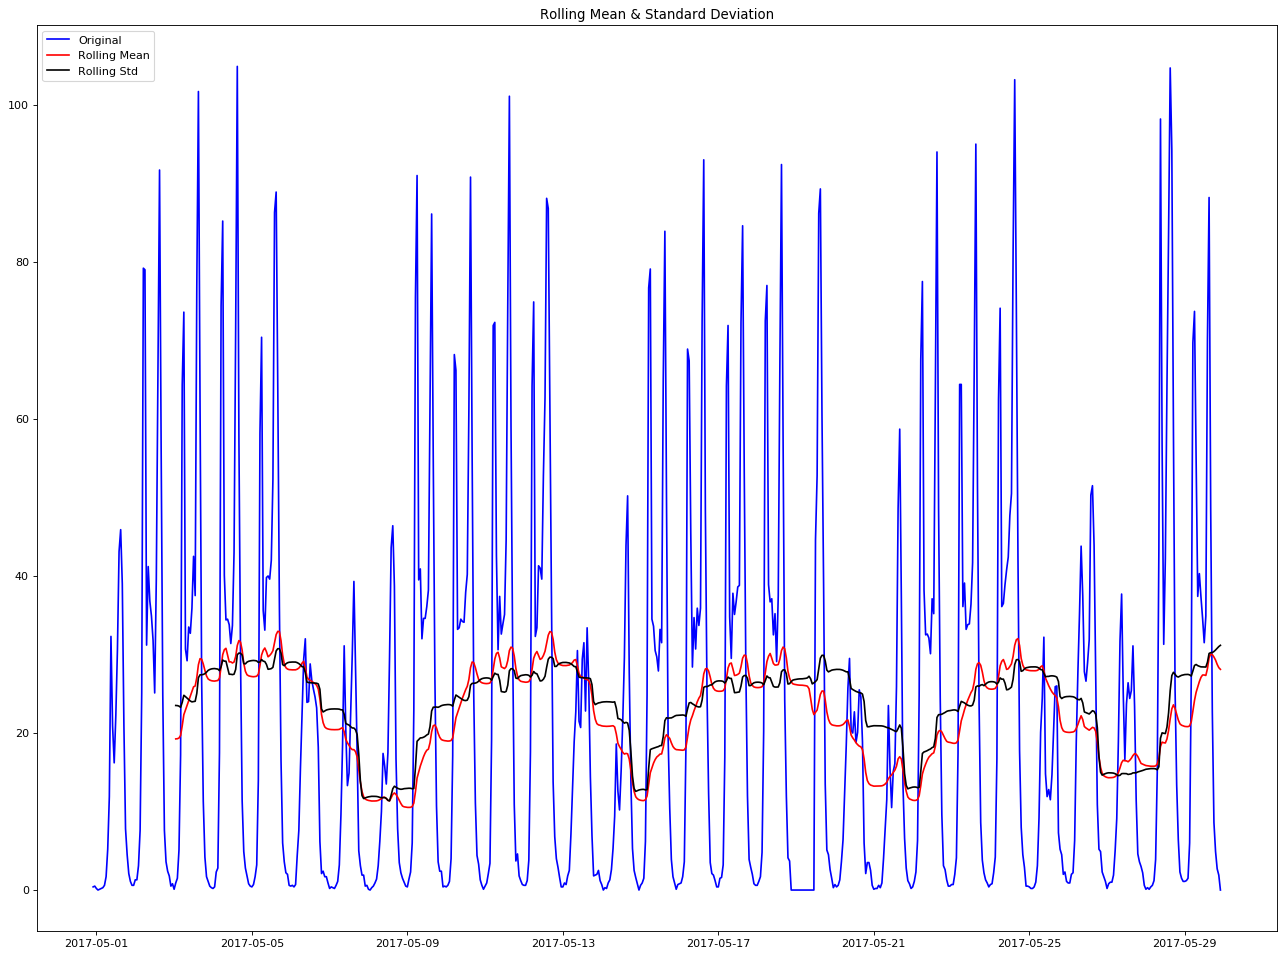

Results of Dickey-Fuller Test:
Test Statistic                  -4.508853
p-value                          0.000190
#Lags Used                      20.000000
Number of Observations Used    676.000000
Critical Value (1%)             -3.440061
Critical Value (5%)             -2.865825
Critical Value (10%)            -2.569052
dtype: float64


In [19]:
check_stationarity(Dataset['qt_dv18'])

Because the test statistic is less than the 5% critical value and the p-value is less  than 0.05, the moving average is  constant over time and the null hypothesis of the Dickey-Fuller test Is rejected. This shows that the hourly time series is stationary.

we can make sure that the time serie is stationary

C:\Users\hp\Anaconda3\envs\Data_imputation\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  if __name__ == '__main__':


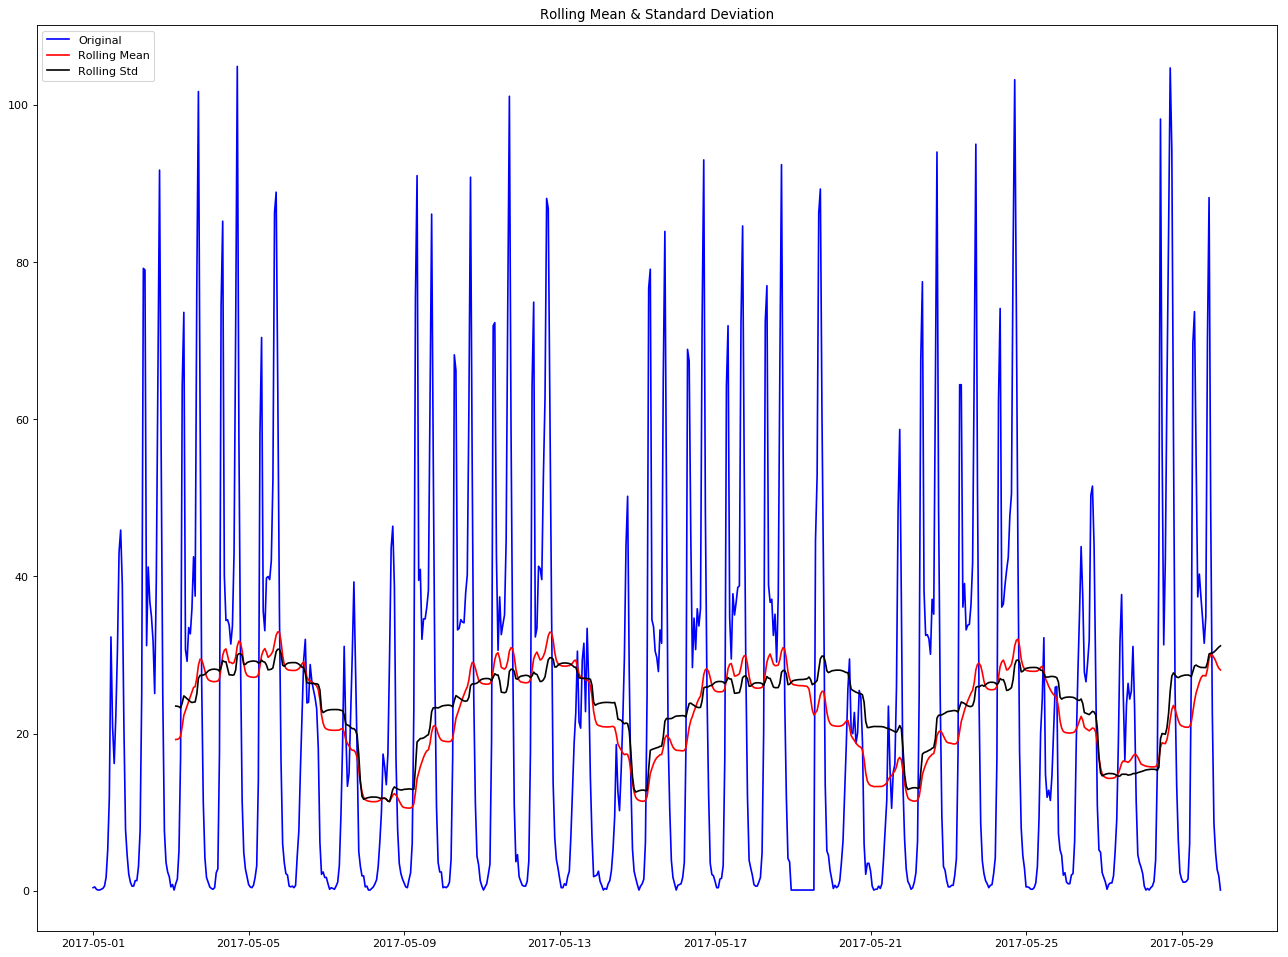

Results of Dickey-Fuller Test:
Test Statistic                  -4.509291
p-value                          0.000189
#Lags Used                      20.000000
Number of Observations Used    676.000000
Critical Value (1%)             -3.440061
Critical Value (5%)             -2.865825
Critical Value (10%)            -2.569052
dtype: float64


In [20]:
def replaceZeroes(data):
      min_nonzero = np.min(data[np.nonzero(data)])
      data[data == 0] = min_nonzero
      return data

data = replaceZeroes(Dataset['qt_dv18'].values)
#np.shape(data)[0]
d = pd.Series(data, index=np.arange(np.shape(data)[0]))
didx = pd.DatetimeIndex(start ='2017-05-01', freq ='1H',periods = np.shape(data)[0]) 

# set the index 
d.index = didx
d.to_frame() 

ts_log = np.log(d)
check_stationarity(d)

data is indeed stationary

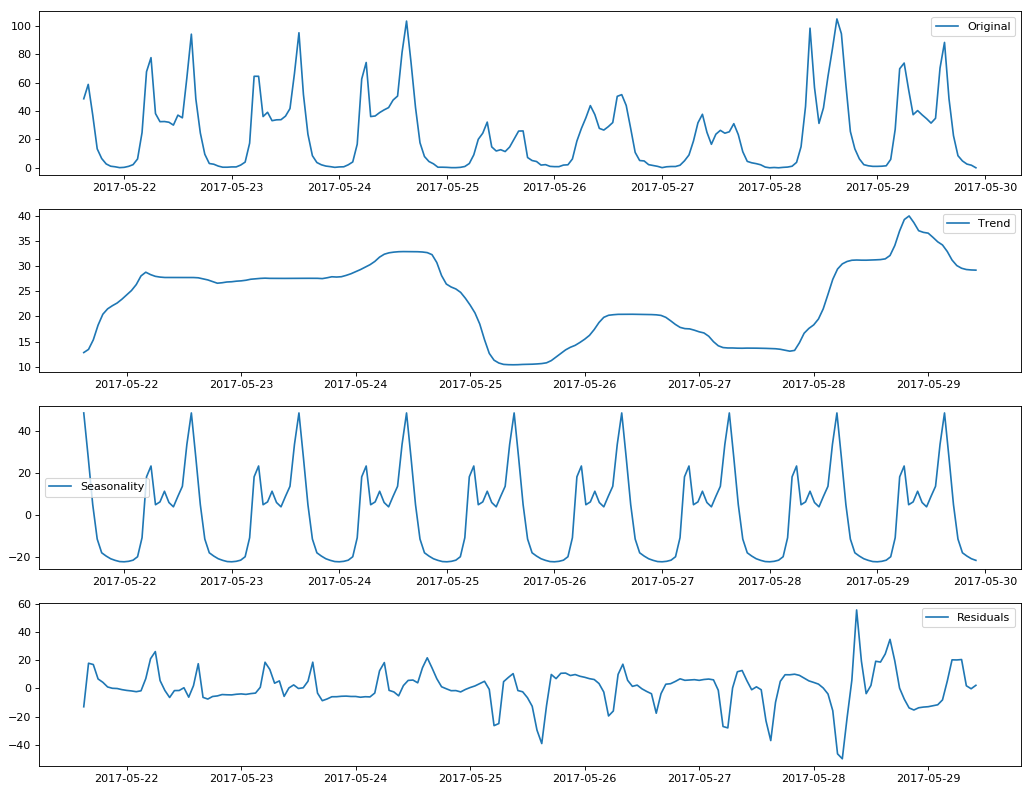

In [21]:
decomposition = seasonal_decompose(Dataset['qt_dv18'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Select the most recent hours 

select = Dataset['qt_dv18'][-200:]

plt.figure(num=1, figsize=(13, 10), dpi=80)
plt.subplot(411)
plt.plot(select.index.to_pydatetime(), select.values, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(select.index.to_pydatetime(), trend[-200:].values, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(select.index.to_pydatetime(), seasonal[-200:].values,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(select.index.to_pydatetime(), residual[-200:].values, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Remove trend and seasonality with differencing
Differencing is one of the most common methods of dealing with both trend and seasonality. In first order differencing, you compute the differences between consecutive observations in the time series. This usually improves the stationarity of the time series. In the code, this is confirmed by running the Dickey-Fuller test.

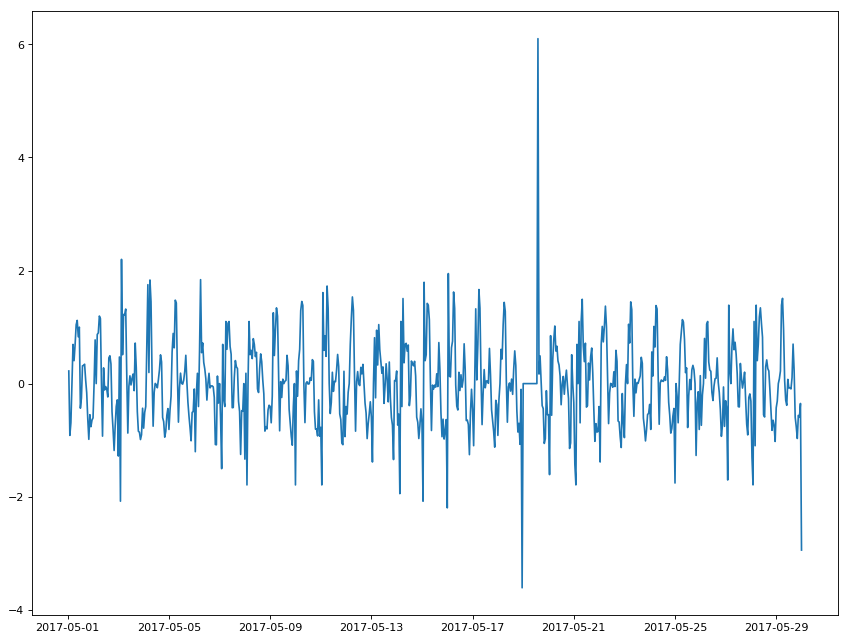

In [22]:
ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(13, 10), dpi=80)

plt.plot(ts_log_diff.index.to_pydatetime(), ts_log_diff.values)

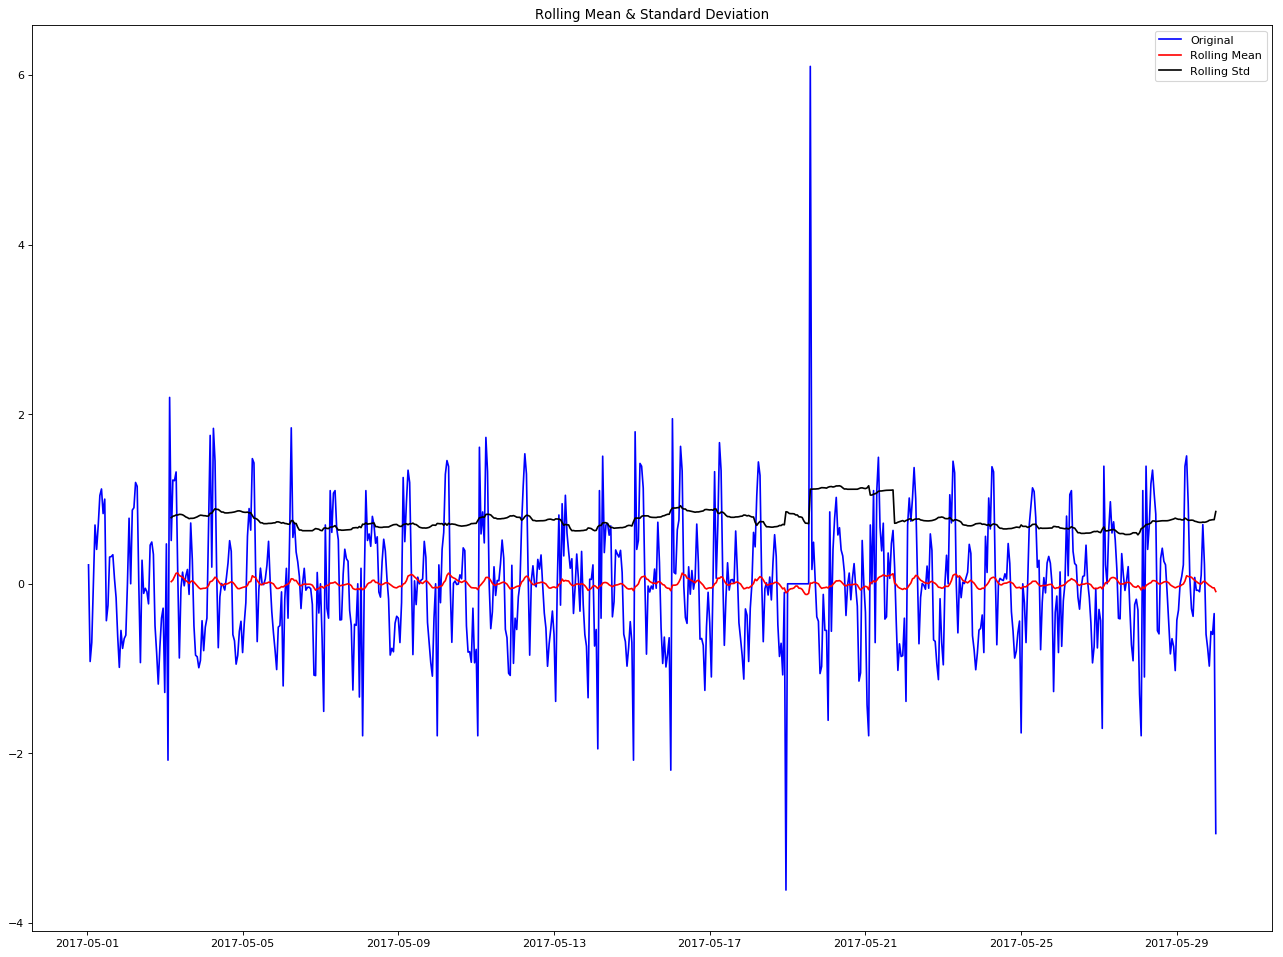

Results of Dickey-Fuller Test:
Test Statistic                -1.497078e+01
p-value                        1.201083e-27
#Lags Used                     2.000000e+01
Number of Observations Used    6.750000e+02
Critical Value (1%)           -3.440075e+00
Critical Value (5%)           -2.865831e+00
Critical Value (10%)          -2.569055e+00
dtype: float64


In [23]:
ts_log_diff.dropna(inplace=True)
check_stationarity(ts_log_diff)

## Finding the optimal model hyper-parameters using auto_arima:
If you are unsure (as is common) of the best parameters for your model, let auto_arima figure it out for you. auto_arima is similar to an ARIMA-specific grid search, but (by default) uses a more intelligent stepwise algorithm laid out in a paper by Hyndman and Khandakar (2008). If stepwise is False, the models will be fit similar to a gridsearch. Note that it is possible for auto_arima not to find a model that will converge; if this is the case, it will raise a ValueError.

auto_arima can fit a random search that is much faster than the exhaustive one by enabling random=True. If your random search returns too many invalid (nan) models, you might try increasing n_fits or making it an exhaustive search.

In [24]:
# fitting a stepwise model:
from pmdarima.arima import auto_arima

stepwise_fit = auto_arima(Dataset['qt_dv18'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=6351.051, BIC=6360.107, Fit time=0.087 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5330.248, BIC=5348.360, Fit time=1.163 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=6238.862, BIC=6252.445, Fit time=0.216 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=5313.847, BIC=5336.486, Fit time=3.697 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5190.250, BIC=5217.418, Fit time=8.485 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5200.243, BIC=5222.883, Fit time=8.817 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=5147.334, BIC=5179.030, Fit time=12.005 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  697
Model:             SARIMAX(2, 1, 1)x(2, 1, 2, 12)   Log Likelihood               -2512.303
Date:                            Wed, 12 Jun 2019   AIC                           5042.606
Time:                                    15:01:18   BIC                           5083.358
Sample:                                         0   HQIC                          5058.376
                                            - 697                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.005     -0.040      0.968      -0.010       0.009
ar.L1          0.9149      0.034     26.929      0.000       0.848       0.982
ar.L2         -0.3505      0.035    -10.049      0.000      -0.419      -0.282
ma.L1         -0.8887      0.025    -35.501      0.000      -0.938      -0.840
ar.S.L12      -1.0816      0.074    -14.620      0.000      -1.227      -0.937
ar.S.L24      -0.0819      0.073     -1.116      0.264      -0.226       0.062
ma.S.L12      -0.0197      7.951     -0.002      0.998     -15.604      15.564
ma.S.L24      -0.9800      7.723     -0.127      0.899     -16.118      14.158
sigma2        79.3726    625.407      0.127      0.899   -1146.403    1305.149
===================================================================================
Ljung-Box (Q):                      149.30   Jarque-Bera (JB):               495.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.21
Prob(H) (two-sided):                  0.28   Kurtosis:                         7.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
from bokeh.plotting import figure, show, output_notebook
import pandas as pd

# init bokeh
output_notebook()

def plot_arima(truth, forecasts, title="ARIMA", xaxis_label='Time',
               yaxis_label='Value', c1='#A6CEE3', c2='#B2DF8A', 
               forecast_start=None, **kwargs):
    
    # make truth and forecasts into pandas series
    n_truth = truth.shape[0]
    n_forecasts = forecasts.shape[0]
    
    # always plot truth the same
    truth = pd.Series(truth, index=np.arange(truth.shape[0]))
    
    # if no defined forecast start, start at the end
    if forecast_start is None:
        idx = np.arange(n_truth, n_truth + n_forecasts)
    else:
        idx = np.arange(forecast_start, n_forecasts)
    forecasts = pd.Series(forecasts, index=idx)
    
    # set up the plot
    p = figure(title=title, plot_height=600, plot_width=900, **kwargs)
    p.grid.grid_line_alpha=0.3
    p.xaxis.axis_label = xaxis_label
    p.yaxis.axis_label = yaxis_label
    
    # add the lines
    p.line(truth.index, truth.values, color=c1, legend='Observed')
    p.line(forecasts.index, forecasts.values, color=c2, legend='Forecasted')
    
    return p

Loading BokehJS ...

In [34]:
in_sample_preds = stepwise_fit.predict_in_sample()
in_sample_preds[:10]

array([-2.04238113e-04,  3.99708621e-01,  4.99581238e-01,  1.99481560e-01,
        9.95295371e-02,  9.95780982e-02,  1.99596846e-01,  2.99581686e-01,
        5.99581521e-01,  1.69961058e+00])

In [36]:
#remmeber data shud be numpy arr
show(plot_arima(Dataset['qt_dv18'].values, in_sample_preds, 
                title="Original Series & In-sample Predictions", 
                c2='#FF0000', forecast_start=0 ))

### Predicting future values
After your model is fit, you can forecast future values using the predict function, just like in sci-kit learn:

In [37]:
next_25 = stepwise_fit.predict(n_periods=25)
next_25
np.shape(Dataset['qt_dv18'].values)

(697,)

In [38]:
# call the plotting func
show(plot_arima(Dataset['qt_dv18'].values, next_25))